In [70]:
from sklearn.linear_model import SGDClassifier
%matplotlib inline 
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [71]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True, data_home="./../sklearn")
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
mnist["data"],mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

这里就是把数据进行了分组。
- X：特征
- y：目标

In [72]:
X, y = mnist["data"], mnist["target"]
X.shape
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [73]:
x_train[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

这个函数，本质上来说，就是把东西拼接数组，组成一个比较大的数组。然后打印那个数组。  

计算机的图片就是一个一个像素点。而一个train set的中的单元，逻辑上来说是一张一张图片，而实现上来说，只是像素点组合成的数组。
而下面这个函数，就是把这些像素点组成的数组拼装起来。

In [74]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

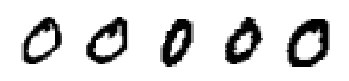

In [75]:
import matplotlib
import matplotlib.pyplot as plt

plot_digits(x_train[:5])
plt.show()

In [76]:
y_train[:5]

array([0, 0, 0, 0, 0], dtype=int8)

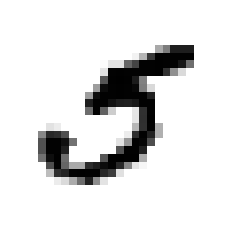

In [77]:
%matplotlib inline 

five_example = mnist["data"][36000]
image = five_example.reshape(28, 28)
plt.axis("off")
plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.show()

mnist 数据的类型，就是把一张图片，拍平成一个数组。然后对数组进行对比。

In [78]:
"每个元素的类型，本质上来说是，{}".format(type(five_example))

"每个元素的类型，本质上来说是，<class 'numpy.ndarray'>"

In [79]:
sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=-np.infty)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

        
sgd_clf.fit(x_train, y_train_5)
sgd_clf.predict([five_example])

array([ True])

下面是交叉验证。

In [80]:
from sklearn.model_selection import StratifiedKFold
skfolds = StratifiedKFold(n_splits=3, random_state=42)



/Users/chandlersong/.conda/envs/MLBase/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
